In [16]:
from historyData.HistoryData import HistoryData
from tinkoff.invest.grpc.marketdata_pb2 import CandleInterval
import asyncio

In [17]:
candle_interval = CandleInterval.CANDLE_INTERVAL_5_MIN
data_set = HistoryData()

In [46]:
candles = None

async def data_get():
    global candles
    candles = await (data_set.GetAllData(candle_interval))

await data_get()

In [54]:
commission = 0.0005
data_index_buy_sell = []

total_earn = 0
total_sum_earned = 0
bought_at = -1
for i, candle in enumerate(list(candles)):
    if i == 0:
        continue
    
    current_price = candle["close"]
    if current_price > candles[i - 1]["close"]:
        if len(data_index_buy_sell) == 0 or list(data_index_buy_sell[-1].keys())[0] == "sold":
            bought_at = candles[i - 1]["close"]
            data_index_buy_sell.append({"bought": i - 1})
        total_earn += current_price - candles[i - 1]["close"]
    elif current_price < candles[i - 1]["close"]:
        data_index_buy_sell.append({"sold": i - 1})
        if total_earn > bought_at * commission + current_price * commission:
            total_sum_earned += total_earn
        total_earn = 0

print(data_index_buy_sell, total_sum_earned)

[{'sold': 0}, {'sold': 1}, {'bought': 2}, {'sold': 4}, {'bought': 5}, {'sold': 7}, {'bought': 8}, {'sold': 10}, {'bought': 11}, {'sold': 12}, {'sold': 13}, {'bought': 14}, {'sold': 15}, {'bought': 16}, {'sold': 19}, {'sold': 20}, {'bought': 21}, {'sold': 23}, {'bought': 24}, {'sold': 26}, {'bought': 27}, {'sold': 28}, {'bought': 29}, {'sold': 32}, {'bought': 33}, {'sold': 34}, {'bought': 35}, {'sold': 39}, {'sold': 40}, {'bought': 42}, {'sold': 46}, {'bought': 47}, {'sold': 49}, {'bought': 50}, {'sold': 54}, {'sold': 56}, {'bought': 57}, {'sold': 59}, {'sold': 60}, {'bought': 61}, {'sold': 62}, {'bought': 63}, {'sold': 64}, {'bought': 65}, {'sold': 66}, {'sold': 67}, {'bought': 68}, {'sold': 69}, {'bought': 70}, {'sold': 71}, {'sold': 72}, {'bought': 73}, {'sold': 78}, {'bought': 79}, {'sold': 83}, {'bought': 84}, {'sold': 85}, {'bought': 86}, {'sold': 87}, {'bought': 88}, {'sold': 92}, {'bought': 93}, {'sold': 94}, {'bought': 95}, {'sold': 96}, {'bought': 97}, {'sold': 98}, {'sold': 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


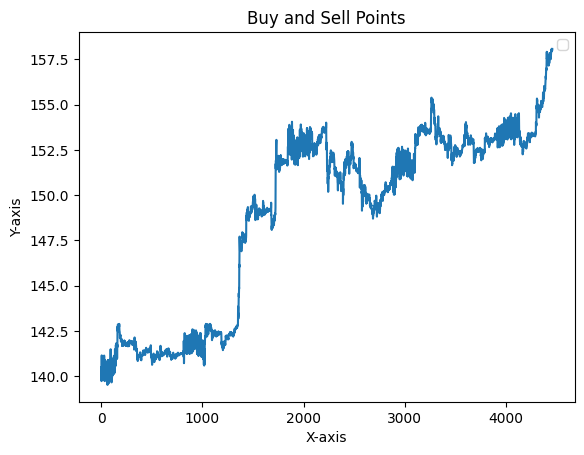

In [52]:
import matplotlib.pyplot as plt

plt.plot([price["close"] for price in candles])

plt.legend()

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Buy and Sell Points')

plt.show()